<a href="https://colab.research.google.com/github/hmlewis-astro/street_network_deep_learning/blob/main/unet_tuned_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change to GPU runtime

#### Navigate to "Runtime > Change runtime type > GPU > Save"


# Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!mkdir figures

#Upload pkl files to Google Drive

The satellite image and mask files, `deep-globe-sat-img-train.pkl`, `deep-globe-mask-train.pkl`, must be in your Google Drive

# Name this model run

In [3]:
run_name = str(input('Name of model run (e.g. base_model, tuned_model_a, etc.): '))

Name of model run (e.g. base_model, tuned_model_a, etc.): final_model


# Import packages and libraries

In [4]:
import os
import glob
import random
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers, models

import tensorflow.keras.backend as K


2.6.0


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print('Found GPU at: \n{}'.format(gpu_info))


Found GPU at: 
Thu Sep 30 16:09:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                         

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Get train/val data

In [7]:
image_size = 256


In [8]:
with open('/content/drive/MyDrive/deep-globe-sat-img-train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/drive/MyDrive/deep-globe-mask-train.pkl', 'rb') as f:
    y_train = pickle.load(f)


In [9]:
X_train = np.array(X_train)
y_train = np.array(y_train)


In [10]:
X_train.shape, y_train.shape


((6226, 256, 256, 3), (6226, 256, 256))

# Display some sample satellite images and corresponding road map masks

In [11]:
def display_img_mask(index):
    
    fig, ax = plt.subplots(1,2, figsize=(8,5))
    
    ax[0].imshow(X_train[index])
    ax[0].set_title('Satellite Image')
    
    ax[1].imshow(y_train[index], cmap='Greys')
    ax[1].set_title('Road Map')


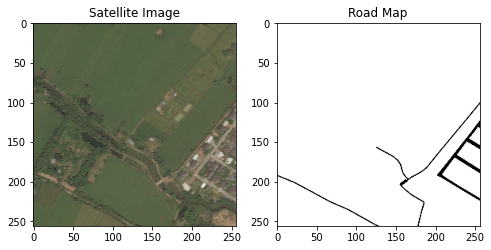

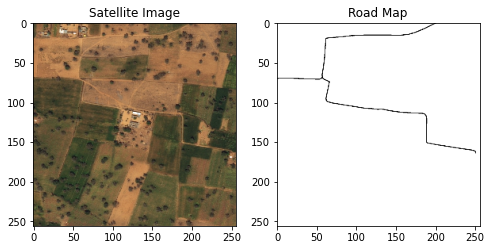

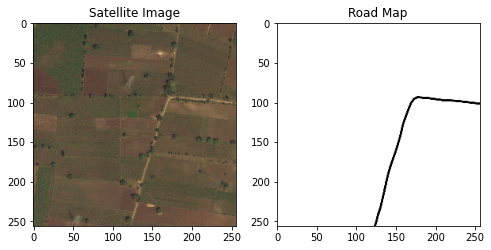

In [12]:
for i in list(np.random.choice(range(len(X_train)), size=3)):
    display_img_mask(i)
    

# Define UNet architecture

In [13]:
def Conv2DBlock(inputs, num_filters, kernel_size, doBatchNorm = True):
    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_initializer='he_normal', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    #x = layers.Activation('elu')(x)
    #x = layers.Activation('leaky_relu')(x)

    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    #x = layers.Activation('elu')(x)
    #x = layers.Activation('leaky_relu')(x)

    return x


In [14]:
def get_unet_model(inputs, num_filters, kernel_size=3, dropout=0.1):
    # encoder
    c1 = Conv2DBlock(inputs, num_filters*1, kernel_size)
    p1 = layers.MaxPooling2D((2,2))(c1)
    p1 = layers.Dropout(dropout)(p1)
    
    c2 = Conv2DBlock(p1, num_filters*2, kernel_size)
    p2 = layers.MaxPooling2D((2,2))(c2)
    p2 = layers.Dropout(dropout)(p2)
    
    c3 = Conv2DBlock(p2, num_filters*4, kernel_size)
    p3 = layers.MaxPooling2D((2,2))(c3)
    p3 = layers.Dropout(dropout)(p3)
    
    c4 = Conv2DBlock(p3, num_filters*8, kernel_size)
    p4 = layers.MaxPooling2D((2,2))(c4)
    p4 = layers.Dropout(dropout)(p4)
    
    c5 = Conv2DBlock(p4, num_filters*16, kernel_size)
    
    # decoder
    u6 = layers.Conv2DTranspose(num_filters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropout)(u6)
    c6 = Conv2DBlock(u6, num_filters*8, kernel_size)
    
    u7 = layers.Conv2DTranspose(num_filters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout)(u7)
    c7 = Conv2DBlock(u7, num_filters*4, kernel_size)
    
    u8 = layers.Conv2DTranspose(num_filters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout)(u8)
    c8 = Conv2DBlock(u8, num_filters*2, kernel_size)
    
    u9 = layers.Conv2DTranspose(num_filters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropout)(u9)
    c9 = Conv2DBlock(u9, num_filters*1, kernel_size)
    
    # output layer
    output = layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    
    model = models.Model(inputs = [inputs], outputs = [output])
    
    return model


# Define custom F1 score metric

In [15]:
def f1_score(y_true, y_pred):    

    def recall_func(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (positives+K.epsilon())    
        return recall 
    
    
    def precision_func(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        pred_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (pred_positives+K.epsilon())
        return precision 
    
    precision, recall = precision_func(y_true, y_pred), recall_func(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Define callbacks, load existing model (if exists), train UNet model

In [16]:
num_filters = 16
kernel_size = 3
dropout = 0.2

tf.keras.backend.clear_session()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=15, verbose=1, 
                                              restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5,
                                                  verbose=1),
             tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/satellite_segmentation_epoch_history.csv',
                                          append=True),
             tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/satellite_segmentation.h5', 
                                                save_best_only=True, save_freq='epoch')]

if os.path.exists('/content/drive/MyDrive/satellite_segmentation.h5'):
    print('Loading previously trained model.')
    unet = models.load_model('/content/drive/MyDrive/satellite_segmentation.h5', custom_objects={'f1_score':f1_score})

else:
    print('Compiling new model.')
    # input layer
    inputs = layers.Input((image_size, image_size, 3))

    # encoder-decoder architecture, output layer
    unet = get_unet_model(inputs, num_filters, kernel_size, dropout)

    unet.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 optimizer=tf.keras.optimizers.RMSprop(),
                 #optimizer=tf.keras.optimizers.SGD(),
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                          f1_score,
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.Precision(name='precision'),
                          tf.keras.metrics.MeanIoU(num_classes=2, name='mIOU'),
                          ])


Compiling new model.


In [17]:
unet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

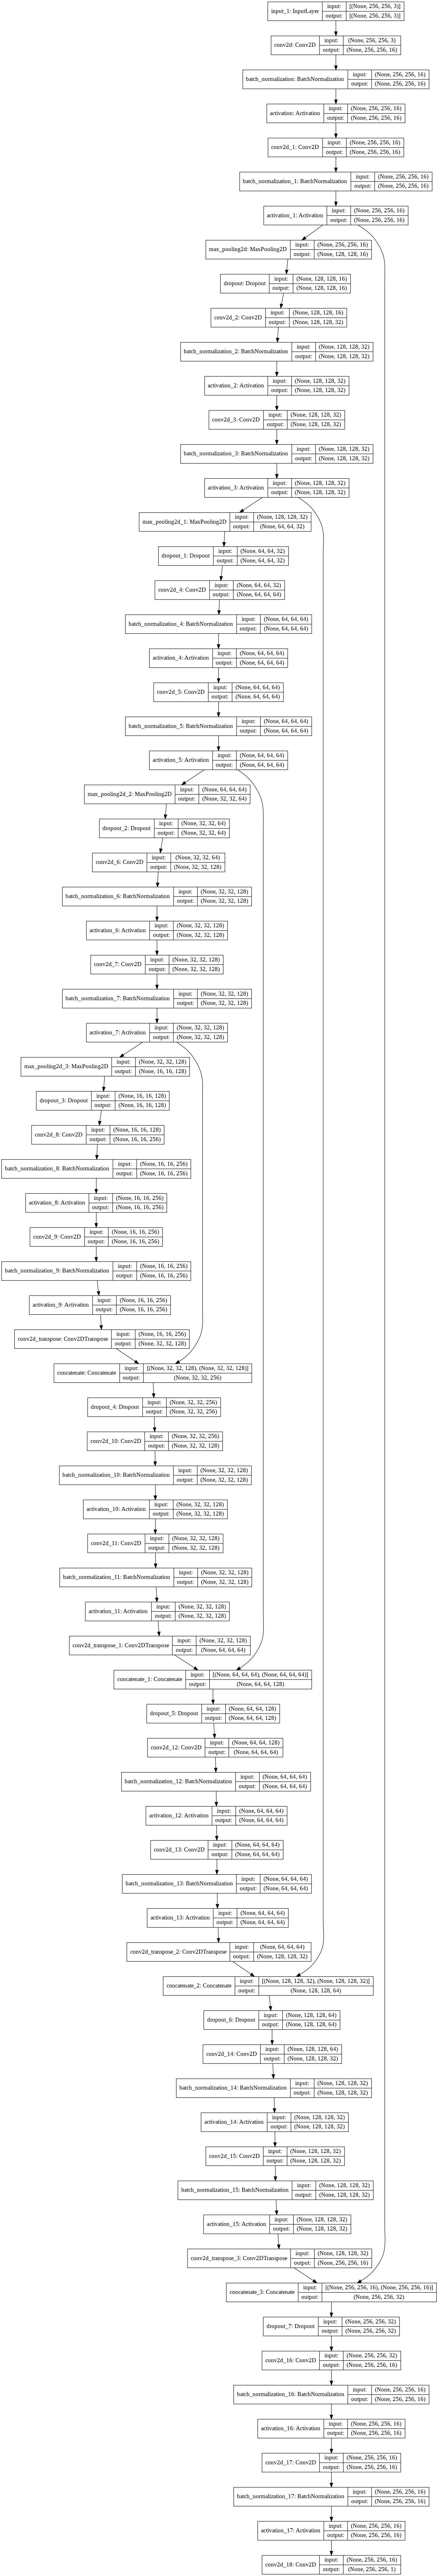

In [18]:
tf.keras.utils.plot_model(unet, to_file='unet_final_model_architecture.png', show_shapes=True, show_layer_names=True)


In [19]:
epochs = 500
history = unet.fit(X_train, y_train,
                       epochs=epochs, batch_size=64,
                       validation_split=0.25, callbacks=callbacks,
                       verbose=1)


Epoch 1/500
73/73 [==============================] - 60s 504ms/step - loss: 0.3356 - accuracy: 0.9291 - f1_score: 0.0226 - recall: 0.0467 - precision: 0.0772 - mIOU: 0.4810 - val_loss: 7.3790 - val_accuracy: 0.3985 - val_f1_score: 0.0814 - val_recall: 0.6573 - val_precision: 0.0502 - val_mIOU: 0.3174
Epoch 2/500
73/73 [==============================] - 35s 481ms/step - loss: 0.2046 - accuracy: 0.9532 - f1_score: 1.8546e-04 - recall: 9.1849e-05 - precision: 0.0321 - mIOU: 0.4810 - val_loss: 0.1733 - val_accuracy: 0.9534 - val_f1_score: 1.4517e-05 - val_recall: 7.1457e-06 - val_precision: 0.0270 - val_mIOU: 0.4809
Epoch 3/500
73/73 [==============================] - 35s 481ms/step - loss: 0.1574 - accuracy: 0.9534 - f1_score: 0.0012 - recall: 5.5032e-04 - precision: 0.5461 - mIOU: 0.4810 - val_loss: 0.1680 - val_accuracy: 0.9534 - val_f1_score: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_mIOU: 0.4809
Epoch 4/500
73/73 [==============================] - 33s 449ms

# Plot metric vs. epoch

In [20]:
def plot_history(history, metric, save_fig=False):
    plt.plot(history.history[f'{metric}'], lw=3.0, color='dodgerblue')
    
    if metric != 'lr':
        plt.plot(history.history[f'val_{metric}'], lw=3.0, ls='--', color='deeppink')
    
    if metric == 'accuracy':
        metric_str = 'Accuracy'
        plt.ylim(0.9, 1.0)
        
    elif metric == 'f1_score':
        metric_str = 'F1 Score'
        
    elif metric == 'loss':
        metric_str = 'Loss'
        plt.ylim(0.05, 0.35)
        
    elif metric == 'lr':
        metric_str = 'Learning Rate'
        
    elif metric == 'recall':
        metric_str = 'Recall'
        
    elif metric == 'precision':
        metric_str = 'Precision'
        
    elif metric == 'mIOU':
        metric_str = 'mIOU'
        
    else:
        matric_str = 'Metric'
        plt.ylim(0.1, 1.0)

    plt.title(f'{metric_str} v. Epoch')
    plt.xlabel('Epoch')
    
    plt.ylabel(f'{metric_str}')
    plt.legend(['Train','Validation'])

    plt.tight_layout()

    if save_fig:
        plt.savefig(f'figures/{metric}_v_epoch_final_model.png', dpi=200)

    plt.close()


In [21]:
metric_list = ['accuracy', 'f1_score', 'recall', 'precision']
for metric in metric_list:
    plot_history(history, metric, save_fig=True)

# Display some sample satellite images, corresponding actual road map mask and predicted road map mask

In [22]:
def display_img_mask_pred(index, save_fig=False):
    
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    
    ax[0].imshow(X_train[index])
    ax[0].set_title('Satellite Image')
    
    ax[1].imshow(y_train[index], cmap='Greys')
    ax[1].set_title('Road Map')
    
    predict_data = unet.predict(X_train[index].reshape(-1, 256, 256, 3))[0]
    
    ax[2].imshow(predict_data[:, :, 0], cmap='Greys')
    ax[2].set_title('Predicted Road Map')
    
    plt.tight_layout()
    
    if save_fig:
      fig.savefig(f'figures/predicted_road_map_{run_name}_{index}.png', dpi=200)
    
    #plt.close()


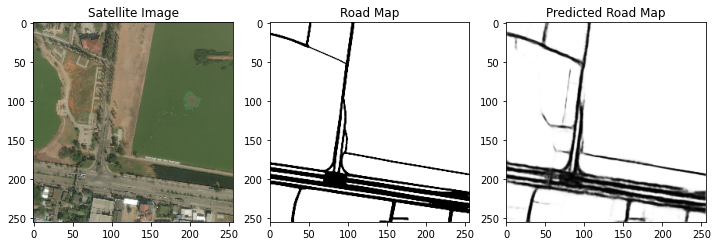

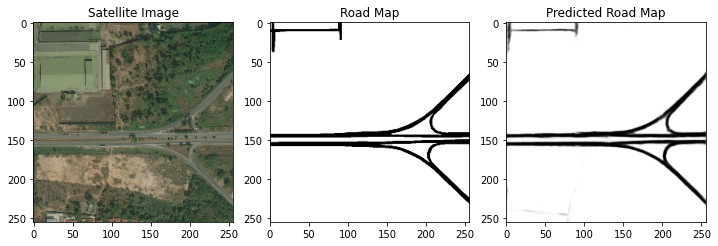

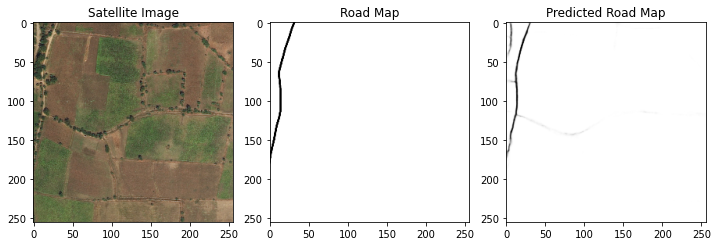

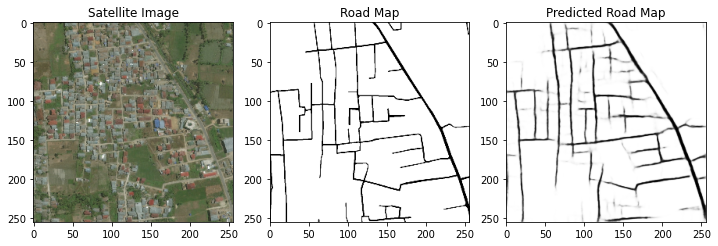

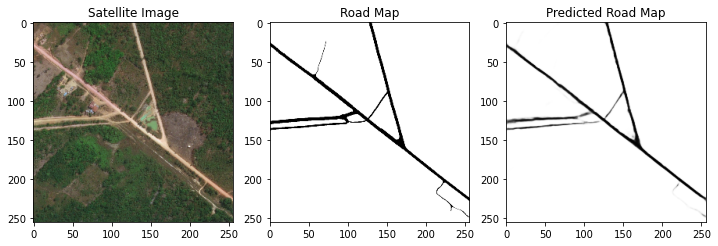

In [24]:
for i in list(np.random.choice(range(len(X_train)), size=5)):
    display_img_mask_pred(i, save_fig=True)

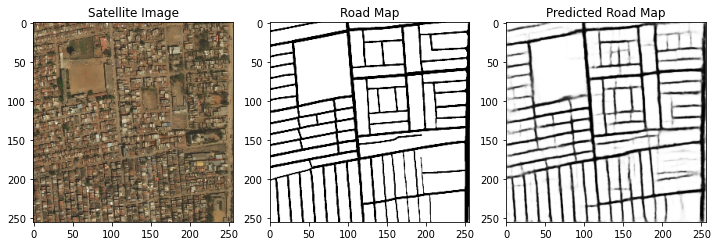

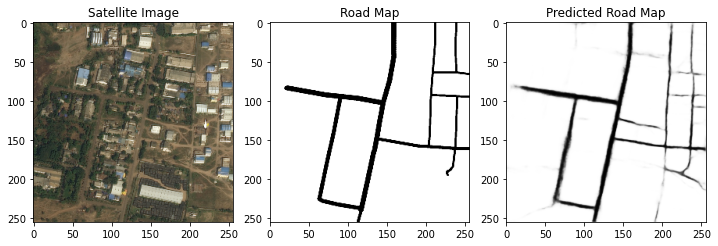

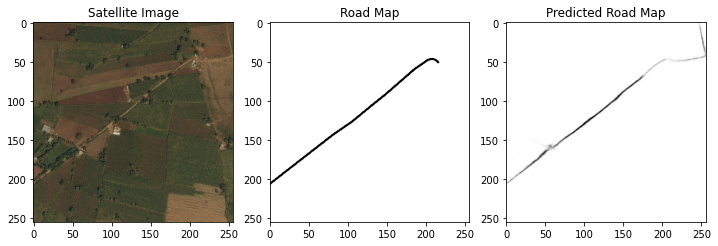

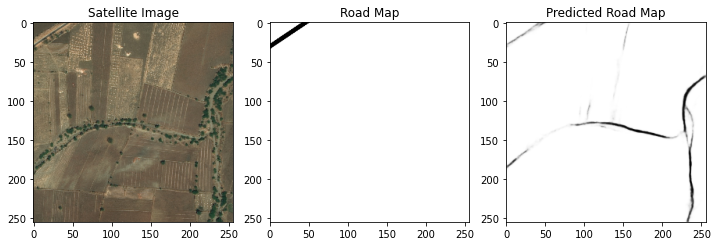

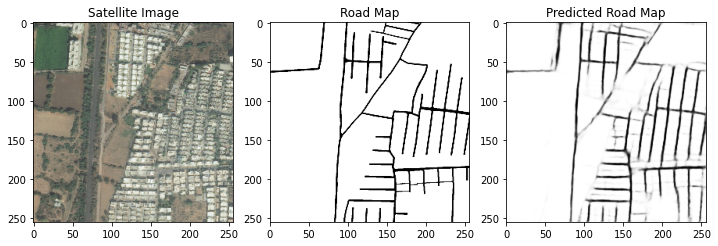

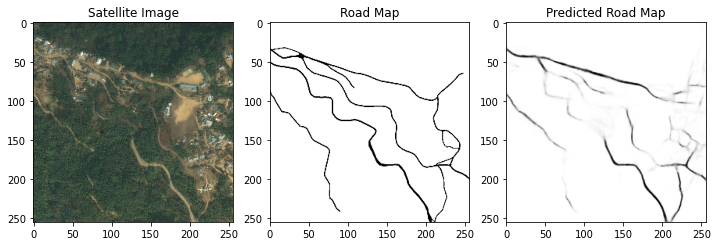

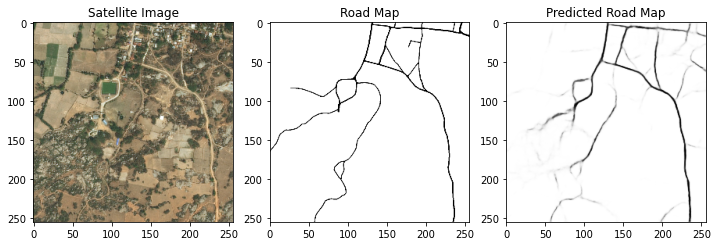

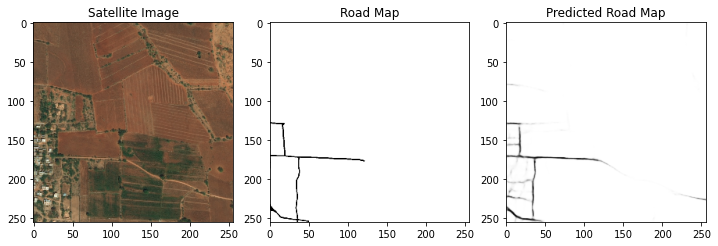

In [25]:
follow_index = [2272, 3492, 5252, 5540, 2896, 6138, 5161, 758]
for i in follow_index:
    display_img_mask_pred(i, save_fig=True)
    

In [28]:
from google.colab import files

fig_files = sorted(glob.glob(f'figures/predicted_road_map_{run_name}_*.png'))

for fig in fig_files:
  files.download(fig) 

for metric in metric_list:
  files.download(f'figures/{metric}_v_epoch_{run_name}.png') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
files.download('/content/drive/MyDrive/satellite_segmentation_epoch_history.csv')
files.download('/content/drive/MyDrive/satellite_segmentation.h5')
files.download('unet_final_model_architecture.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 4.9 MB/s 


In [38]:
import visualkeras

from PIL import ImageFont

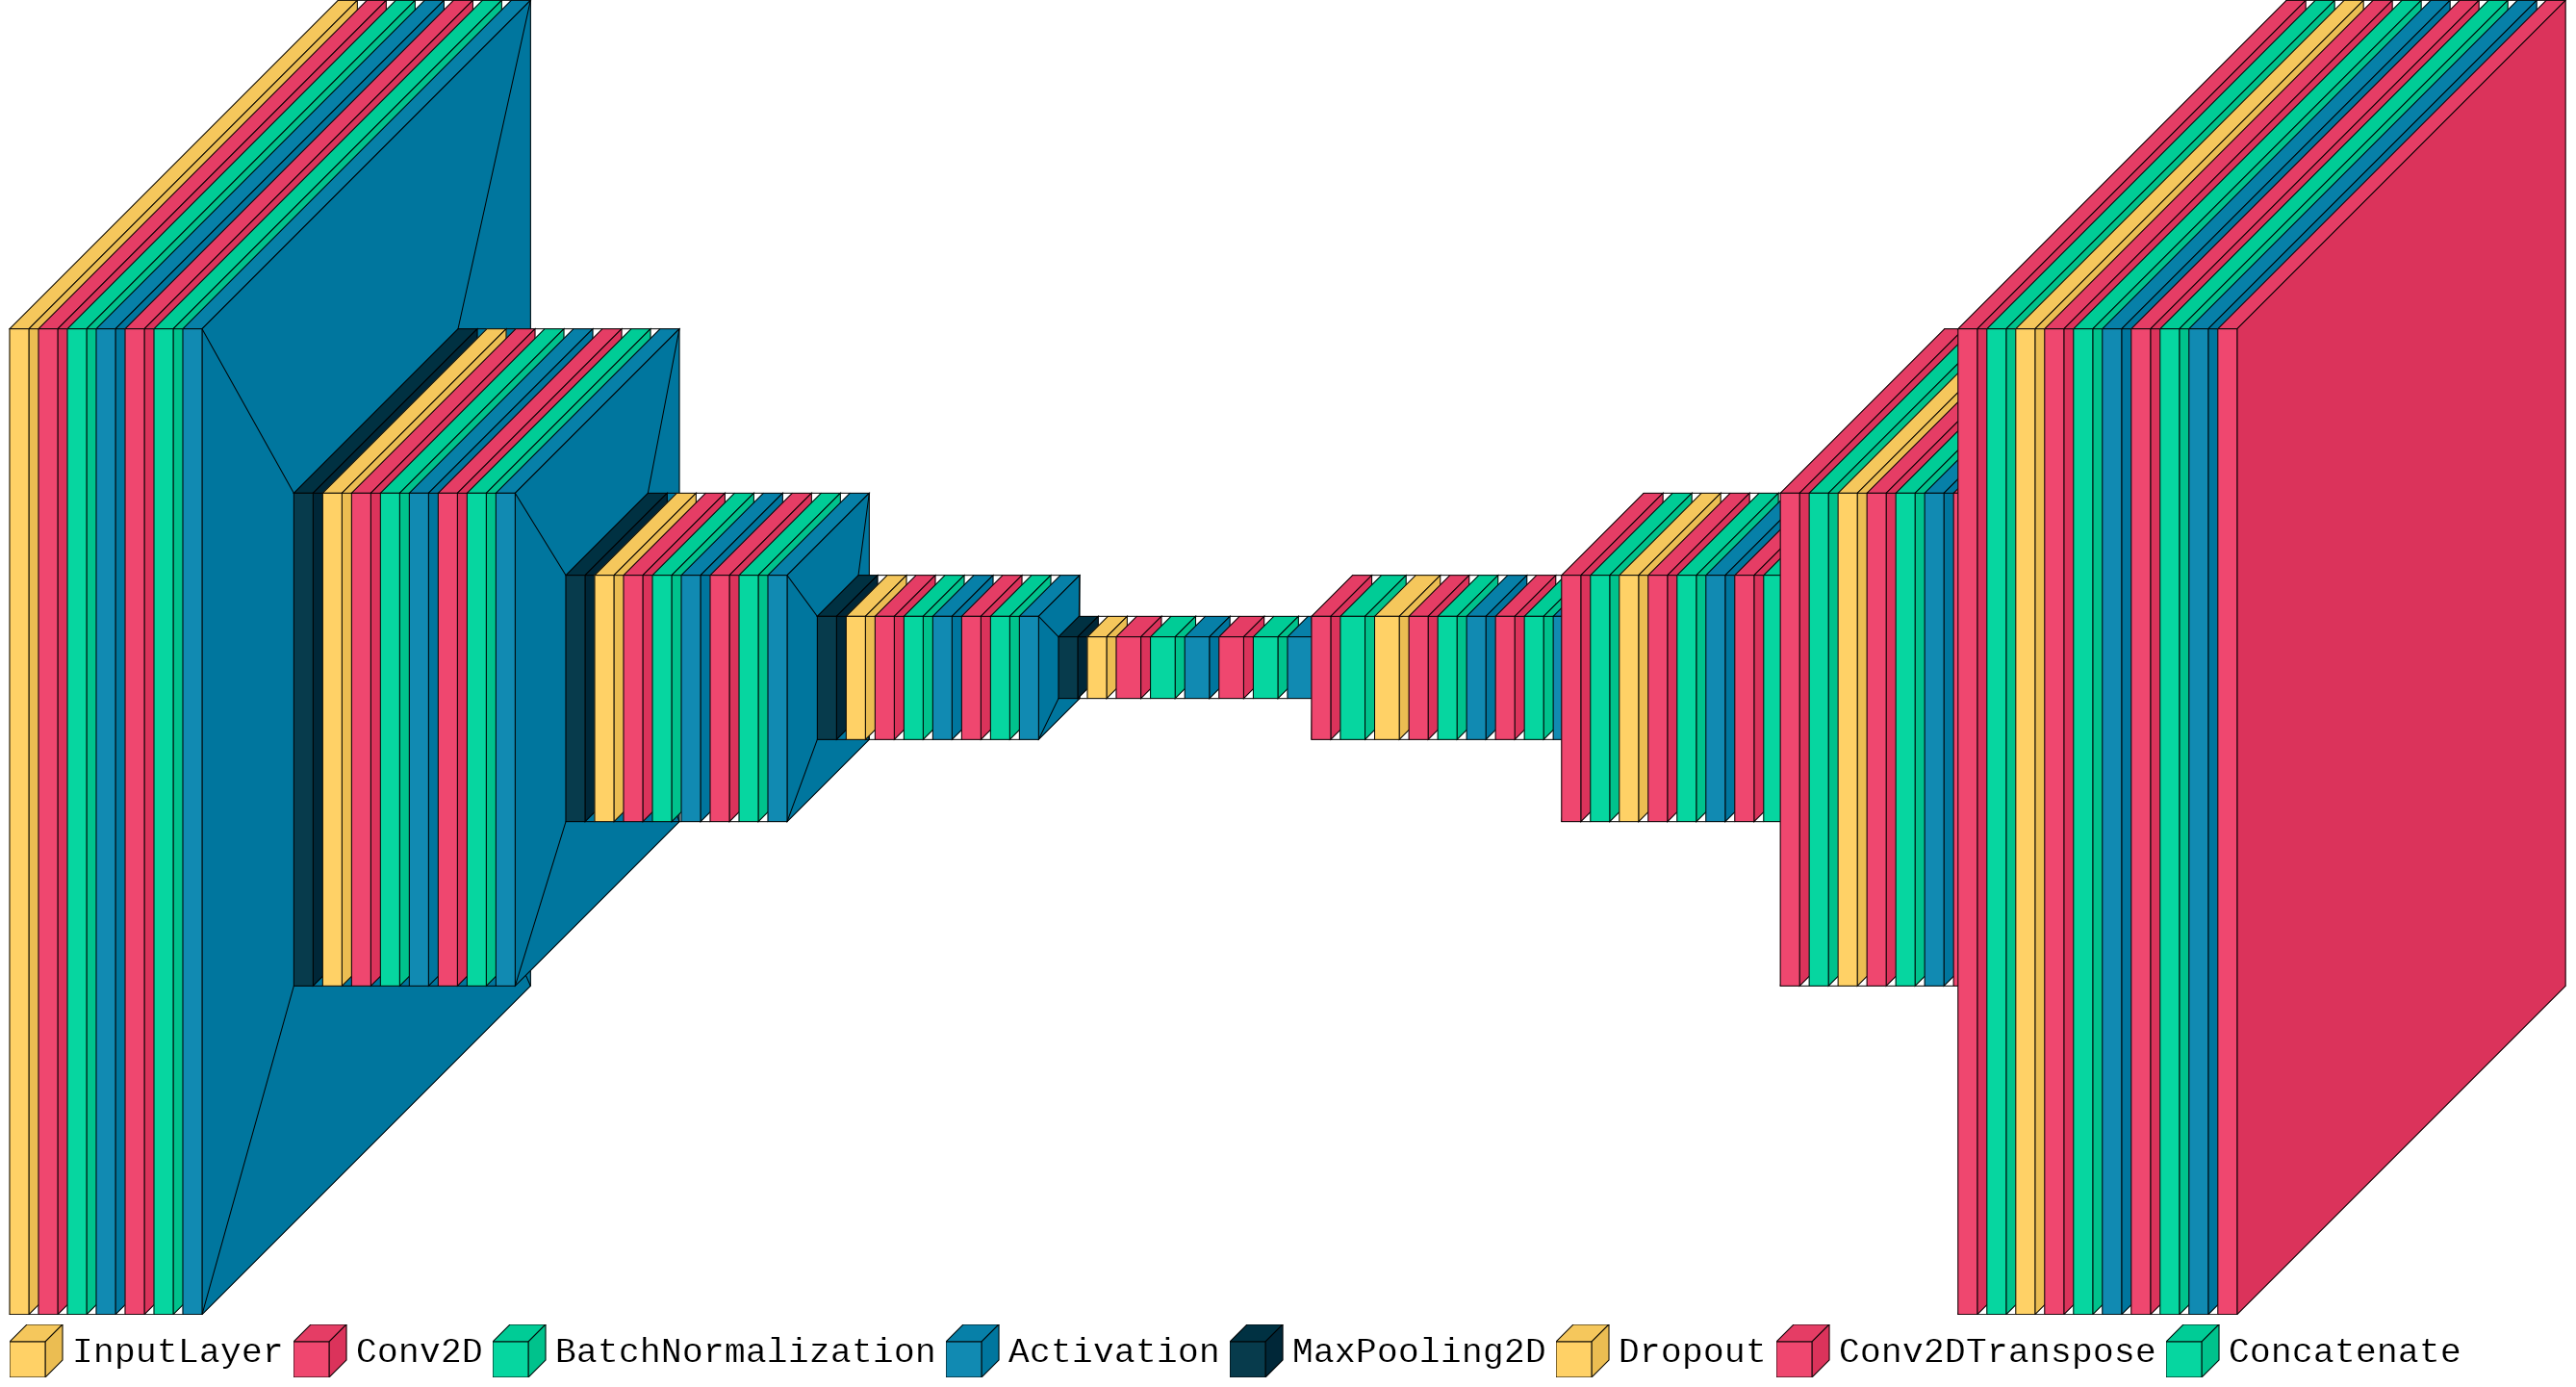

In [47]:
font = ImageFont.truetype('/usr/share/fonts/truetype/LiberationMono-Regular.ttf', 36) 

visualkeras.layered_view(unet, 
                         font=font,
                         legend=True,
                         to_file='figures/unet_final_model_architecture_visualkeras.png')


In [48]:
files.download('figures/unet_final_model_architecture_visualkeras.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>